In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/code-to-cure-10/metaData.csv
/kaggle/input/code-to-cure-10/submission_attempt.csv
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/code-to-cure-10/Training/pituitary/Tr-pi_0789.jpg
/kaggle/

In [2]:
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input


In [3]:
# !pip install torch timm fastai

In [4]:
import timm
from fastai.vision.all import *
from fastcore.all import *

In [5]:
path = '/kaggle/input/code-to-cure-10/Training'

In [6]:
torch.cuda.empty_cache()
import gc
gc.collect()

23

In [7]:
# import torch
# import torch_xla.core.xla_model as xm

# # Initialize the TPU device
# device = xm.xla_device()

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.654674,0.351733,0.874641,01:06


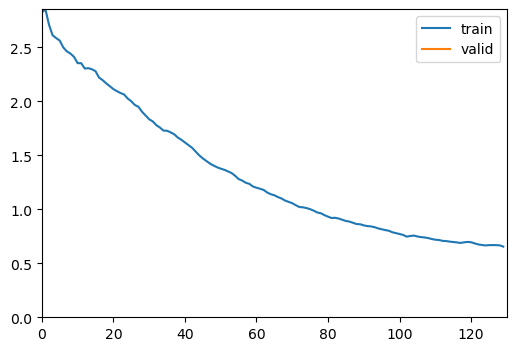

epoch,train_loss,valid_loss,accuracy,time


In [ ]:


# Define the transforms to apply
data_augmentation = aug_transforms(
    do_flip=True, 
    flip_vert=True, 
    max_rotate=20, # 20 - 40
    max_zoom=1.5,  #1.4 - 1.8
    max_lighting=0.2,  # 0.5
    max_warp=0.2, #0.2
    p_affine=0.75, 
    p_lighting=0.75
)
# transforms = [aug_transforms(do_flip=True, flip_vert=True),
#               Rotate(max_deg=10.0, p=0.75),
#               Zoom(max_zoom=1.1, p=0.75),
#               Warp(p=0.75),
#               RandomBrightnessContrast(p=0.75, brightness_max=0.2, contrast_max=0.2)]

# Create the datablock and dataloaders
brain_scan = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(224, method='squish')], 
    batch_tfms=[*data_augmentation, Normalize.from_stats(*imagenet_stats)]
)

train_dl = brain_scan.dataloaders(path, bs=32)

# Define the model architecture
learner = cnn_learner(train_dl, 'vit_base_patch16_224', metrics=[accuracy], cbs=[ShowGraphCallback()])

# Train the model
learner.fine_tune(7)

In [9]:
# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_image_files, 
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),
#     get_y=parent_label,
#     item_tfms=[Resize(192, method='squish')]
# ).dataloaders(path, bs=32)

# dls.show_batch(max_n=6)

In [10]:
# learn = vision_learner(dls, resnet101, metrics=error_rate)
# learn.fine_tune(3)

In [11]:
clas,_,probs = learner.predict(PILImage.create('/kaggle/input/code-to-cure-10/Testing/0017.jpg'))
print(f"This is a: {clas}.")

This is a: meningioma.


In [12]:
# define path to your test set
test_path = '/kaggle/input/code-to-cure-10/Testing'

# create a dataloader for the test set
test_dl = learner.dls.test_dl(get_image_files(test_path))

# get predictions for all images in the test set
preds, _ = learner.get_preds(dl=test_dl)

# get the predicted labels as integers
labels = preds.argmax(dim=1)

In [13]:
labels.shape


torch.Size([480])

In [14]:
df = pd.DataFrame(labels)

In [15]:
df.index.name = 'ID'
df.columns = ['Label'] 

In [16]:
filename = os.listdir("/kaggle/input/code-to-cure-10/Testing")

In [17]:
names = []
for x in filename : 
    names.append(x[1:4])

In [18]:
df['ID'] = names

In [19]:
df

,Label,ID
ID,,
0,1,733
1,2,285
2,0,077
3,3,989
4,2,235
...,...,...
475,3,526
476,1,001
477,3,492


In [20]:
df.to_csv('submission_96.csv' , index=False)

In [21]:
df

,Label,ID
ID,,
0,1,733
1,2,285
2,0,077
3,3,989
4,2,235
...,...,...
475,3,526
476,1,001
477,3,492
